# 02 - Exploratory Data Analysis (EDA) & Cleaning

This notebook explores the processed dataset, identifies patterns, distributions, correlations, and potential issues.  
It also performs any additional cleaning necessary before feature engineering.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

# Plotting style
sns.set(style="whitegrid")

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
PROCESSED_PATH = Path("../data/processed/student_dropout_cleaned.csv")

# Load processed data
df = pd.read_csv(PROCESSED_PATH)
print("Processed dataset shape:", df.shape)
display(df.head())


Processed dataset shape: (600, 5)


,attendance_percent,test_score,discipline_count,parental_involvement,dropout_risk
0,79.93428306022466,76.35482924968028,5.0,2.0,1
1,NaN,51.167520137335615,2.0,5.0,0
2,82.95377076201385,78.0440888015849,3.0,3.0,0
3,100.0,85.33456788207427,5.0,2.0,1
4,65.31693250553329,71.20152354835551,5.0,5.0,1


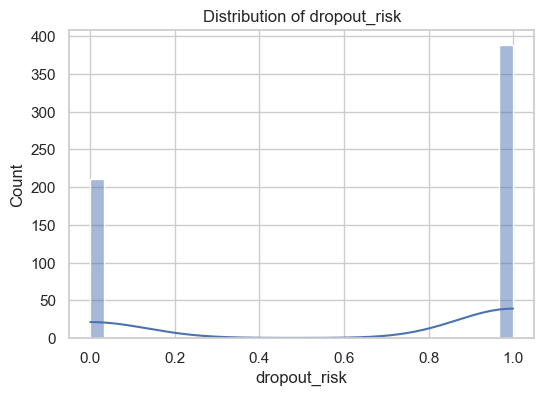

In [3]:
# distribution of numeric columns
numeric_cols = df.select_dtypes(include='number').columns

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()


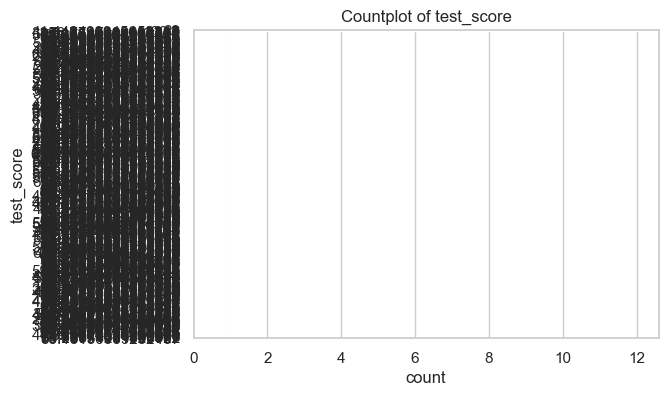

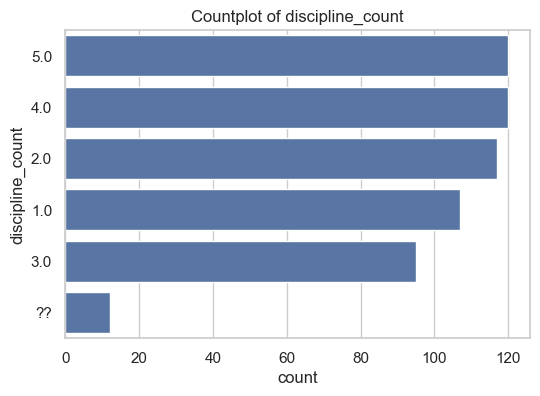

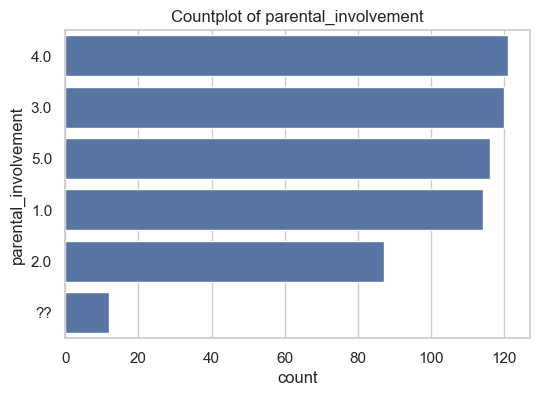

In [7]:


df['attendance_percent'] = (
    df['attendance_percent']
    .replace('%', '', regex=True)                # remove percent sign if any
    .apply(pd.to_numeric, errors='coerce')       # convert to float, invalid becomes NaN
)




categorical_cols = df.select_dtypes(include='object').columns
df['attendance_percent'] = df['attendance_percent'].replace('%', '', regex=True).astype(float)

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f"Countplot of {col}")
    plt.show()


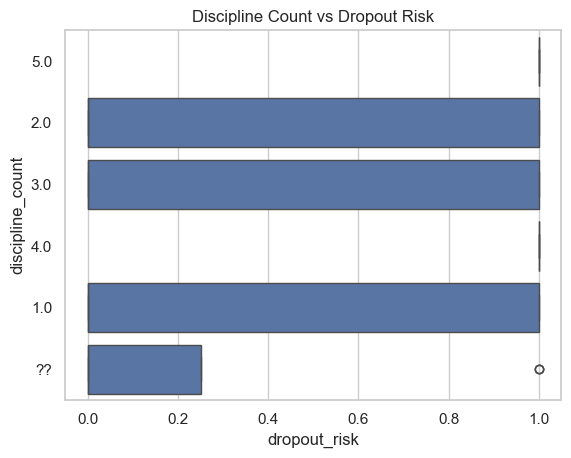

In [8]:
sns.boxplot(x='dropout_risk', y='discipline_count', data=df)
plt.title("Discipline Count vs Dropout Risk")
plt.show()


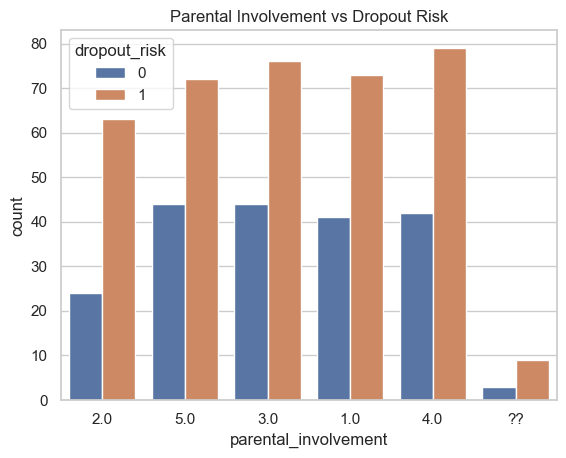

In [9]:
sns.countplot(x='parental_involvement', hue='dropout_risk', data=df)
plt.title("Parental Involvement vs Dropout Risk")
plt.show()


After coercion to numeric:
attendance_percent      float64
test_score              float64
discipline_count        float64
parental_involvement    float64
dropout_risk              int64
dtype: object
Correlation matrix shape: (5, 5)
                      attendance_percent  test_score  discipline_count  \
attendance_percent              1.000000   -0.038172          0.049574   
test_score                     -0.038172    1.000000         -0.043690   
discipline_count                0.049574   -0.043690          1.000000   
parental_involvement           -0.033799   -0.056498          0.028243   
dropout_risk                   -0.497741   -0.014952          0.539122   

                      parental_involvement  dropout_risk  
attendance_percent               -0.033799     -0.497741  
test_score                       -0.056498     -0.014952  
discipline_count                  0.028243      0.539122  
parental_involvement              1.000000     -0.028373  
dropout_risk              

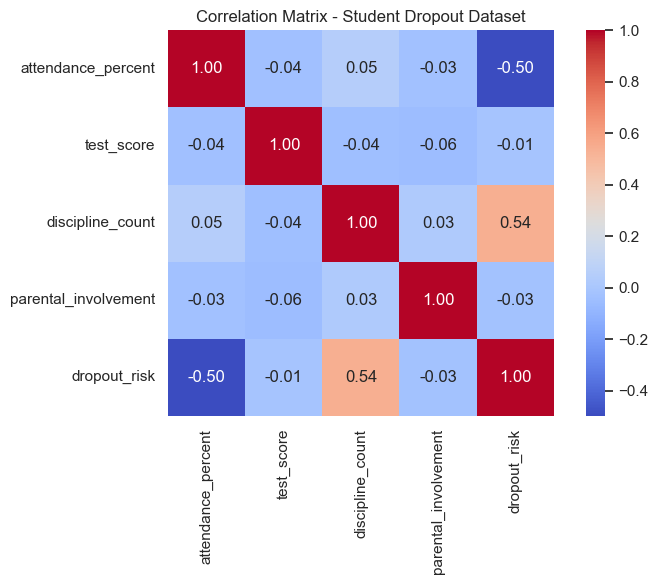

Plotted correlation heatmap using Pearson on numeric columns.


In [11]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print('After coercion to numeric:')
print(df.dtypes)

# Compute correlation matrix using Pearson, dropping columns that are completely NaN
numeric_df = df.select_dtypes(include=[np.number])
numeric_df = numeric_df.dropna(how='all', axis=1)

corr = numeric_df.corr(method='pearson')
print('Correlation matrix shape: ' + str(corr.shape))
print(corr.head())

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Matrix - Student Dropout Dataset')
plt.tight_layout()
plt.show()

print('Plotted correlation heatmap using Pearson on numeric columns.')

Dropout risk is moderately negatively correlated with attendance and positively correlated with discipline count.

In [ ]:
# detecting outliers
def detect_outliers_iqr(df, columns):
    outlier_indices = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices[col] = outliers.tolist()
        
        print(f"{col}: {len(outliers)} outliers (lower < {lower_bound:.2f}, upper > {upper_bound:.2f})")
    return outlier_indices

numeric_cols = ['attendance_percent', 'discipline_count', 'test_score', 'parental_involvement']
outliers_iqr = detect_outliers_iqr(df, numeric_cols)


attendance_percent: 1 outliers (lower < 15.62, upper > 122.26)
discipline_count: 0 outliers (lower < -1.00, upper > 7.00)
test_score: 5 outliers (lower < 27.77, upper > 104.33)
parental_involvement: 0 outliers (lower < -1.00, upper > 7.00)


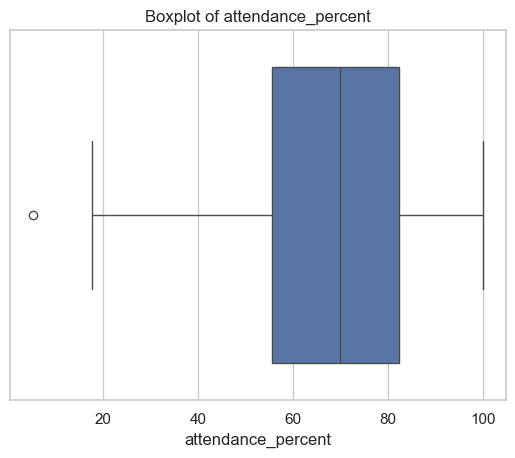

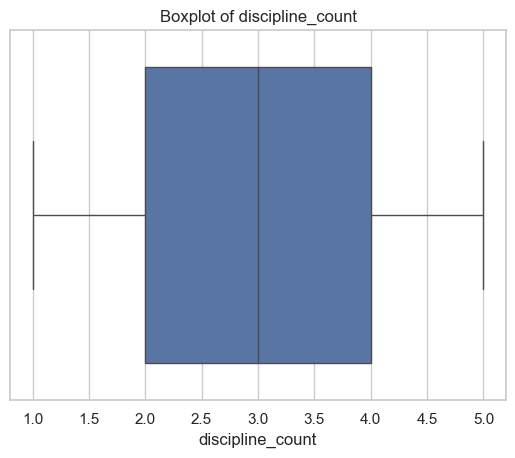

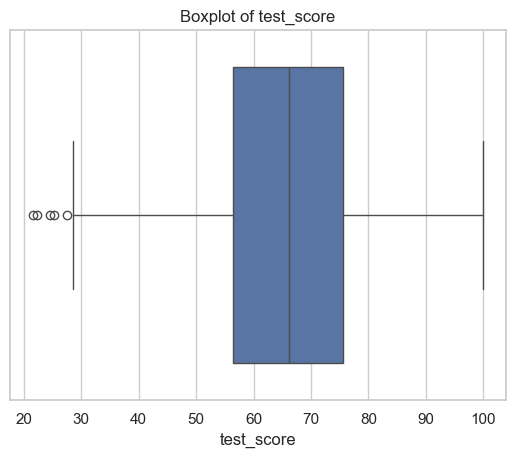

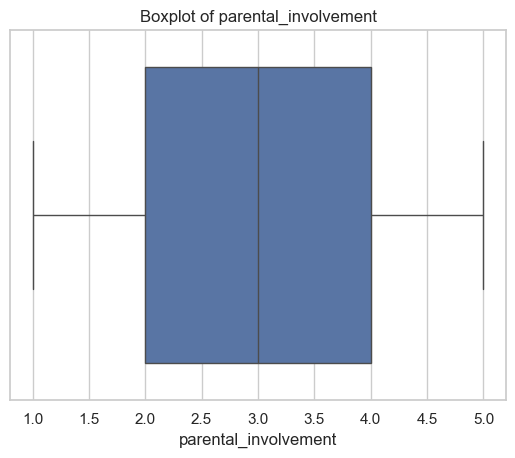

In [ ]:
# confirming outliers
for col in numeric_cols:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


In [14]:


def cap_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap values outside the bounds
        df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
        print(f"{col}: capped outliers outside [{lower_bound:.2f}, {upper_bound:.2f}]")
    return df_clean

numeric_cols = ['attendance_percent', 'discipline_count', 'test_score', 'parental_involvement']
df_clean = cap_outliers_iqr(df, numeric_cols)


attendance_percent: capped outliers outside [15.62, 122.26]
discipline_count: capped outliers outside [-1.00, 7.00]
test_score: capped outliers outside [27.77, 104.33]
parental_involvement: capped outliers outside [-1.00, 7.00]


In [15]:
# Save cleaned dataset for feature engineering
FEATURES_PATH = Path("../data/processed/student_data_eda_cleaned.csv")
df.to_csv(FEATURES_PATH, index=False)
print(f"EDA-cleaned data saved at: {FEATURES_PATH}")

EDA-cleaned data saved at: ..\data\processed\student_data_eda_cleaned.csv
